<a href="https://colab.research.google.com/github/shgyg99/handwrittenmathsolutions/blob/main/mathtolatex.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch

torch.cuda.is_available()

True

# **🔴ENVIRONMENT SETUP**

In [2]:
!pip install -q torchmetrics
!pip install -q wandb
!pip install -q fastai
!pip install -q pytorch_lightning

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 927.3/927.3 kB 42.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 50.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 54.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 29.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 18.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 61.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 819.3/819.3 kB 42.6 MB/s eta 0:00:00


In [3]:
# !pip uninstall torchvision torch -y
# !pip install -q torch==2.5 torchvision==0.20

# **🔴IMPORT LIBS**

In [2]:
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
from collections import defaultdict
import os
from torch.nn.utils.rnn import pad_sequence
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random

import torchvision
from torchvision import transforms as TT
from torchvision.models import resnet50, ResNet50_Weights
from torchvision.utils import make_grid

import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset, random_split
from torch import optim
from torch.nn import functional as F

from tokenizers import Tokenizer, models, trainers, pre_tokenizers
import wandb
import tqdm
import torchmetrics as tm
from PIL import Image

from argparse import Namespace
from typing import List, Optional

# import hydra
# from omegaconf import DictConfig
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import Callback, EarlyStopping, ModelCheckpoint, LearningRateMonitor
from torch.optim.lr_scheduler import ReduceLROnPlateau
from pytorch_lightning.loggers.wandb import WandbLogger

# **🔴UTILS**

In [3]:

class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [4]:
def num_trainable_params(model):
  nums = sum(p.numel() for p in model.parameters() if p.requires_grad)/1e6
  return nums

In [5]:
def set_seed(seed):
  np.random.seed(seed)
  torch.manual_seed(seed)
  if torch.cuda.is_available():
      torch.cuda.manual_seed(seed)

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **🔴ARGUMENTS**

In [7]:
config = {
    "seed": 1234,

    "trainer": {
        "overfit_batches": 0.0,
        "check_val_every_n_epoch": 2,
        "fast_dev_run": False,
        "max_epochs": 100,
        "min_epochs": 1,
        "num_sanity_val_steps": 0,
    },

    "callbacks": {
        "model_checkpoint": {
            "save_top_k": 1,
            "save_weights_only": True,
            "mode": "min",
            "monitor": "val/loss",
            "dirpath": "/content/drive/MyDrive/papersFolder/model_checkpoints",
            "filename": "{epoch}-{val/loss:.2f}-{val/cer:.2f}"
        },
        "early_stopping": {
            "patience": 3,
            "mode": "min",
            "monitor": "val/loss",
            "min_delta": 0.001
        },
        "LearningRateMonitor":{
            "logging_interval": "epoch"
        }
    },

    "data": {
        "batch_size": 16,
        "num_workers": 4,
        "pin_memory": True
    },

    "lit_model": {
        # Optimizer
        "lr": 0.0001,
        "weight_decay": 0.00001,

        # Scheduler
        "milestones": [10],
        "gamma": 0.5,

        # Model
        "d_model": 128,
        "dim_feedforward": 256,
        "nhead": 4,
        "dropout": 0,
        "num_decoder_layers": 3,
        "max_output_len": 200
    },

    "logger": {
        "project": "image-to-latex"
    }
}

In [8]:
path = '/content/drive/MyDrive/papersFolder/'

# **🔴CUSTOM DATASET**

In [9]:
# df = pd.read_csv(os.path.join(path, 'merged_sorted.csv'))
# latex_formulas = df.iloc[:, 1]
# with open(os.path.join(path, 'latex_formulas.txt'), 'w', encoding='utf-8') as f:
#   for formula in latex_formulas:
#     f.write(formula + '\n')

# print('Done!')

In [10]:
# tokens = [
#     '\\', '{', '}', '^', '+', '-', "'", '_', '!', '.', '/', '&', '%', '*', '\\div', '\\geq',
#     '\\leq', '\\frac', '\\times', '\\lim', '\\sin', '\\cos', '\\tan', '\\csc', '\\sec',
#     '\\sqrt', '\\sum', '\\rightarrow', '\\Rightarrow', '\\leftarrow', '\\Leftarrow',
#     '\\right', '\\left', '\\alpha', '\\beta', '|', '\\Delta', '\\delta', '\\gamma', '\\lambda',
#     '\\min', '\\max', '(', ')', '<', '>', '=', '\\pm', '\\mp', '\\neq', '\\infty', '\\matrix',
#     '[', ']', '\\in', '\\notin', '\\cap', '\\cup', '\\begin', '\\end', '\\dots', '\\int', ':',
#     '\\ln', '\\pi', '\\theta', '\\to', '\\arctan', '\\arccot', '\\arcsin', '\\arccos',
#     '\\log', '\\sinh', '\\cosh', '\\coth', '\\tanh', '\\degree', '\\sim',
#     '\\forall', '\\emptyset', '\\buildrelF', '\\bar', '\\exists', '\\varepsilon', '\\partial',
#     '\\hat', '\\triangle', '\\mathbb', '\\simeq',
#     'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z',
#     '0', '1', '2', '3', '4', '5', '6', '7', '8', '9'
# ]

# tokenizer = Tokenizer(models.BPE())

# special_tokens = ["<s>", "</s>", "<unk>", "<pad>"] + tokens
# trainer = trainers.BpeTrainer(vocab_size=len(special_tokens), special_tokens=special_tokens)

# tokenizer.pre_tokenizer = pre_tokenizers.Whitespace()

# files = ["/content/drive/MyDrive/papersFolder/latex_formulas.txt"]
# tokenizer.train(files, trainer)

# # ذخیره مدل
# tokenizer.save("/content/drive/MyDrive/papersFolder/latex_tokenizer.json")

# print("✅Done")

In [11]:
def target_transform(label):
  tokenizer = Tokenizer.from_file(f"{path}/latex_tokenizer.json")
  encoded_label = tokenizer.encode(f'<s>{label}</s>')
  return torch.LongTensor(encoded_label.ids)

In [12]:
image_transform = TT.Compose([
    TT.Grayscale(num_output_channels=1),
    TT.Resize((256, 512)),
    TT.ToTensor(),
    TT.Normalize(mean=[0.5], std=[0.5])
])

In [13]:
import os
import random
import pandas as pd
from PIL import Image
from torch.utils.data import Dataset

class LatexImages(Dataset):
    _all_cropped_files = None

    def __init__(self, path, phase, image_transform=None, target_transform=None):
        self.path = path
        self.image_transform = image_transform
        self.target_transform = target_transform
        self.phase = phase

        csv = pd.read_csv(os.path.join(self.path, 'merged_sorted.csv'))

        self.image_paths = []
        self.labels = []

        # پردازش پوشه‌ی "cropped"
        if LatexImages._all_cropped_files is None:
            cropped_folder = os.path.join(self.path, 'cropped')
            LatexImages._all_cropped_files = os.listdir(cropped_folder)
            random.shuffle(LatexImages._all_cropped_files)

        if phase == 'train':
            start, end = 0, 5600
        elif phase == 'valid':
            start, end = 5600, 6600
        else:  # test
            start, end = 6600, 7000

        selected_files = LatexImages._all_cropped_files[start:end]

        for i in selected_files:
            image_path = fr'.\cropped\{i}'
            try:
                label = csv[csv['Image Path'] == image_path]['LaTeX Label'].values[0]
                self.image_paths.append(image_path)
                self.labels.append(label)
            except:
                print(f"Image not found in CSV: {image_path}")

        # پردازش سایر پوشه‌ها
        for folder in ['Symbols', 'EnglishAlphabet', 'PersianNumbers']:
            folder_path = os.path.join(self.path, folder)
            extra_files = []  # لیست را در هر تکرار خالی می‌کنیم

            for subfolder in os.listdir(folder_path):
                subfolder_path = os.path.join(folder_path, subfolder)
                for fil in os.listdir(subfolder_path):
                    extra_files.append(fr'.\{folder}\{subfolder}\{fil}')

            random.shuffle(extra_files)
            total_count = len(extra_files)
            train_count = int(0.8 * total_count)
            valid_count = int(0.2 * total_count)

            if phase == 'train':
                selected_files = extra_files[:train_count]
            elif phase == 'valid':
                selected_files = extra_files[train_count:train_count + valid_count]
            else:
                selected_files = extra_files[train_count + valid_count:]

            for image_path in selected_files:
                try:
                    label = csv[csv['Image Path'] == image_path]['LaTeX Label'].values[0]
                    self.image_paths.append(image_path)
                    self.labels.append(label)
                except:
                    pass

    def __getitem__(self, index):
        try:
          image_path = os.path.join(self.path, self.image_paths[index].split('\\')[1], self.image_paths[index].split('\\')[2], self.image_paths[index].split('\\')[3])
        except:
          image_path = os.path.join(self.path, self.image_paths[index].split('\\')[1], self.image_paths[index].split('\\')[2])
        if self.target_transform:
            label = self.target_transform(self.labels[index])
        else:
            label = self.labels[index]

        image = Image.open(image_path)
        if self.image_transform:
            image = self.image_transform(image)

        return image, label

    def __len__(self):
        return len(self.image_paths)


In [14]:
train_dataset = LatexImages(path=path, phase="train", image_transform=image_transform, target_transform=target_transform)
valid_dataset = LatexImages(path=path, phase="valid", image_transform=image_transform, target_transform=target_transform)
test_dataset = LatexImages(path=path, phase="test", image_transform=image_transform, target_transform=target_transform)

print(len(train_dataset))  # 4000 + other folders
print(len(valid_dataset))  # 1500 + other folders
print(len(test_dataset))  # 1500


20943
4831
362


torch.Size([1, 256, 512]) torch.Size([3])


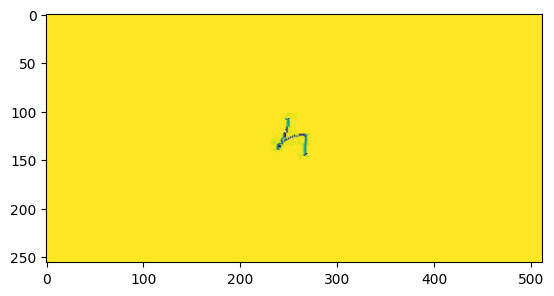

In [15]:
im, la = train_dataset.__getitem__(np.random.randint(0, train_dataset.__len__()))

plt.imshow(TT.ToPILImage()(im))
print(im.shape, la.shape)

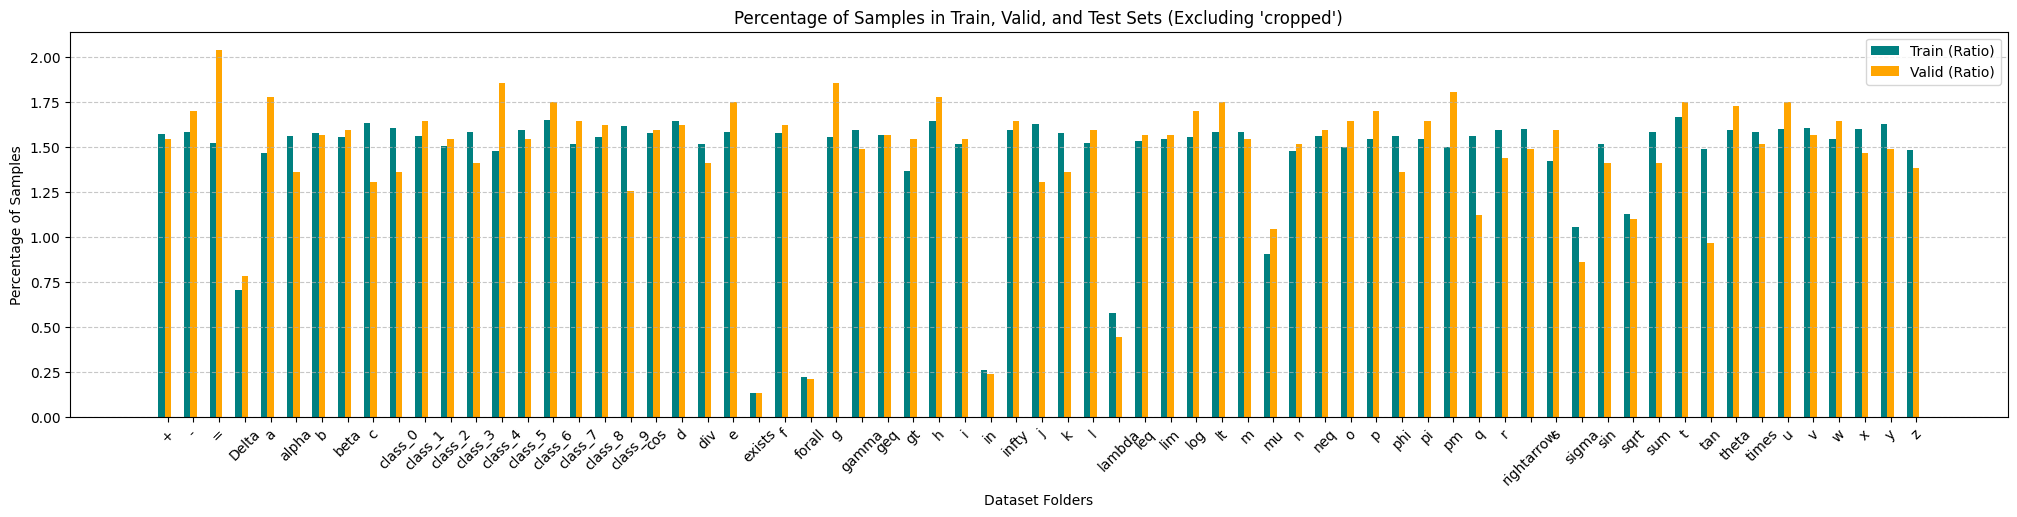

In [16]:
def count_samples(dataset):
    folder_counts = defaultdict(int)
    for image_path in dataset.image_paths:
        folder_name = image_path.split('\\')[-2]
        folder_counts[folder_name] += 1
    return folder_counts

# دریافت تعداد نمونه‌ها برای هر مجموعه
train_counts = count_samples(train_dataset)
valid_counts = count_samples(valid_dataset)

# حذف پوشه "cropped" از لیست پوشه‌ها
all_folders = sorted(set(train_counts.keys()) | set(valid_counts.keys()))
all_folders = [folder for folder in all_folders if folder != "cropped"]

# استخراج تعداد نمونه‌ها و محاسبه نسبت‌ها (در صورت نبود مقدار برای یک پوشه، مقدار ۰ در نظر گرفته می‌شود)
train_values = [train_counts.get(folder, 0) for folder in all_folders]
valid_values = [valid_counts.get(folder, 0) for folder in all_folders]
# محاسبه نسبت‌ها به صورت درصد
total_train = sum(train_values)
total_valid = sum(valid_values)
train_ratios = [count / total_train * 100 if total_train != 0 else 0 for count in train_values]
valid_ratios = [count / total_valid * 100 if total_valid != 0 else 0 for count in valid_values]

# تنظیمات نمودار
x = np.arange(len(all_folders))  # موقعیت برچسب‌های محورها
width = 0.25  # عرض هر میله

plt.figure(figsize=(25, 5))

# رسم میله‌ها برای نسبت‌ها فقط
plt.bar(x - width, train_ratios, width, label='Train (Ratio)', color='teal')
plt.bar(x, valid_ratios, width, label='Valid (Ratio)', color='orange')

# تنظیمات نمودار
plt.xlabel("Dataset Folders")
plt.ylabel("Percentage of Samples")
plt.title("Percentage of Samples in Train, Valid, and Test Sets (Excluding 'cropped')")
plt.xticks(ticks=x, labels=all_folders, rotation=45)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)

# نمایش نمودار
plt.show()


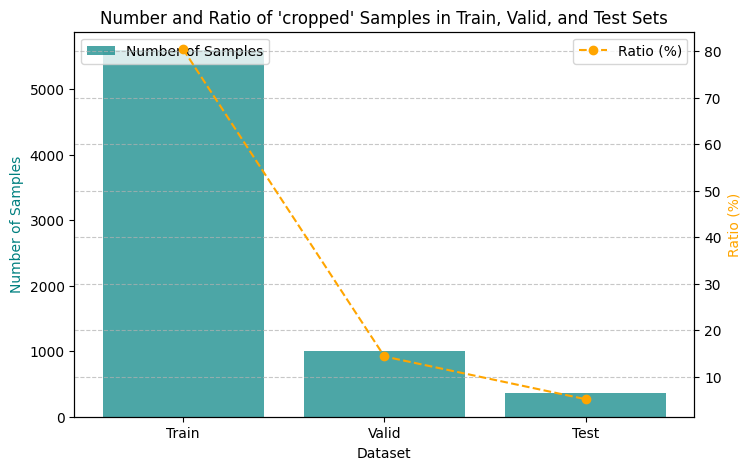

In [17]:
def count_cropped_samples(dataset):
    folder_counts = defaultdict(int)
    for image_path in dataset.image_paths:
        folder_name = image_path.split('\\')[-2]
        if folder_name == "cropped":  # فقط پوشه "cropped" را در نظر می‌گیریم
            folder_counts[folder_name] += 1
    return folder_counts

# دریافت تعداد نمونه‌ها برای پوشه "cropped"
train_cropped_counts = count_cropped_samples(train_dataset)
valid_cropped_counts = count_cropped_samples(valid_dataset)
test_cropped_counts = count_cropped_samples(test_dataset)

# تعداد نمونه‌ها
train_cropped_value = train_cropped_counts.get("cropped", 0)
valid_cropped_value = valid_cropped_counts.get("cropped", 0)
test_cropped_value = test_cropped_counts.get("cropped", 0)

# محاسبه نسبت‌ها
total_train = train_cropped_value + valid_cropped_value + test_cropped_value
train_ratio = (train_cropped_value / total_train * 100) if total_train != 0 else 0
valid_ratio = (valid_cropped_value / total_train * 100) if total_train != 0 else 0
test_ratio = (test_cropped_value / total_train * 100) if total_train != 0 else 0

# تنظیمات نمودار
x = ['Train', 'Valid', 'Test']
values = [train_cropped_value, valid_cropped_value, test_cropped_value]
ratios = [train_ratio, valid_ratio, test_ratio]

# رسم نمودار
fig, ax1 = plt.subplots(figsize=(8, 5))

# نمودار میله‌ای برای تعداد
ax1.bar(x, values, color='teal', alpha=0.7, label="Number of Samples")

# رسم نمودار میله‌ای برای نسبت‌ها
ax2 = ax1.twinx()  # ایجاد محور دوم برای نسبت‌ها
ax2.plot(x, ratios, color='orange', marker='o', label="Ratio (%)", linestyle='--')

# تنظیمات نمودار
ax1.set_xlabel("Dataset")
ax1.set_ylabel("Number of Samples", color='teal')
ax2.set_ylabel("Ratio (%)", color='orange')
ax1.set_title("Number and Ratio of 'cropped' Samples in Train, Valid, and Test Sets")

# نمایش لیجند‌ها
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


# **🔴Data Loader**

In [32]:
from torch.nn.utils.rnn import pad_sequence

def collate_fn(data):
    token = Tokenizer.from_file(f"{path}/latex_tokenizer.json")
    pad_value = token.get_vocab().get('<pad>', 3)

    tensors, targets = zip(*data)

    targets = [torch.tensor(t, dtype=torch.long) for t in targets]

    # ✅ `batch_first=True` باعث می‌شود `targets` به `[batch_size, max_seq_len]` تبدیل شود
    targets_padded = pad_sequence(targets, batch_first=True, padding_value=pad_value)

    tensors = torch.stack(tensors)

    return tensors, targets_padded


In [33]:
train_loader = DataLoader(train_dataset, shuffle=True, collate_fn=collate_fn, **config['data'])
valid_loader = DataLoader(valid_dataset, shuffle=False, collate_fn=collate_fn, **config['data'])
test_loader = DataLoader(test_dataset, shuffle=False, collate_fn=collate_fn, **config['data'])

In [20]:
x, y = next(iter(train_loader))
x.shape, y.shape

(torch.Size([16, 1, 256, 512]), torch.Size([16, 27]))

# **🔴Metric**

In [21]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [22]:
from torchmetrics import Metric
import torch
from torch import Tensor
import editdistance
from typing import Set
class CharacterErrorRate(Metric):
    def __init__(self, ignore_indices: Set[int], *args):
        super().__init__(*args)
        self.ignore_indices = ignore_indices
        self.add_state("error", default=torch.tensor(0.0), dist_reduce_fx="sum")
        self.add_state("total", default=torch.tensor(0), dist_reduce_fx="sum")
        self.error: Tensor
        self.total: Tensor

    def update(self, preds, targets):
        N = preds.shape[0]
        for i in range(N):
            pred = [token for token in preds[i].tolist() if token not in self.ignore_indices]
            target = [token for token in targets[i].tolist() if token not in self.ignore_indices]
            distance = editdistance.distance(pred, target)
            if max(len(pred), len(target)) > 0:
                self.error += distance / max(len(pred), len(target))
        self.total += N

    def compute(self) -> Tensor:
        return self.error / self.total


# **🔴Functions**

In [39]:
from pathlib import Path
from typing import List

import torch
import torch.nn as nn
from pytorch_lightning import LightningModule

class LitResNetTransformer(LightningModule):
    def __init__(
        self,
        d_model: int,
        dim_feedforward: int,
        nhead: int,
        dropout: float,
        num_decoder_layers: int,
        max_output_len: int,
        lr: float = 0.001,
        weight_decay: float = 0.0001,
        milestones: List[int] = [5],
        gamma: float = 0.1,
        save_path: str = path,  # مسیر ذخیره‌سازی پیش‌فرض
    ):
        super().__init__()
        self.save_hyperparameters()
        self.lr = lr
        self.weight_decay = weight_decay
        self.milestones = milestones
        self.gamma = gamma
        self.test_step_outputs = []  # ذخیره نتایج تست
        self.path = save_path  # ذخیره مسیر در کلاس
        self.tokenizer = Tokenizer.from_file(f"{self.path}/latex_tokenizer.json")
        self.model = ResNetTransformer(
            d_model=d_model,
            dim_feedforward=dim_feedforward,
            nhead=nhead,
            dropout=dropout,
            num_decoder_layers=num_decoder_layers,
            max_output_len=max_output_len,
            sos_index=self.tokenizer.get_vocab()["<s>"],
            eos_index=self.tokenizer.get_vocab()["</s>"],
            pad_index=self.tokenizer.get_vocab()["<pad>"],
            num_classes=self.tokenizer.get_vocab_size(),
        )
        self.loss_fn = nn.CrossEntropyLoss(ignore_index=self.tokenizer.get_vocab()["<pad>"])
        self.val_cer = CharacterErrorRate({self.tokenizer.get_vocab()["<pad>"], self.tokenizer.get_vocab()["<s>"], self.tokenizer.get_vocab()["</s>"]})
        self.test_cer = CharacterErrorRate({self.tokenizer.get_vocab()["<pad>"], self.tokenizer.get_vocab()["<s>"], self.tokenizer.get_vocab()["</s>"]})

    def training_step(self, batch, batch_idx):
        imgs, targets = batch
        logits = self.model(imgs, targets[:, :-1])  # گرفتن لاجیت‌ها
        loss = self.loss_fn(logits.permute(0, 2, 1), targets[:, 1:])  # محاسبه‌ی لاس
        self.log("train/loss", loss)
        return loss

    def validation_step(self, batch, batch_idx):
        imgs, targets = batch
        logits = self.model(imgs, targets[:, :-1])
        loss = self.loss_fn(logits.permute(0, 2, 1), targets[:, 1:])
        self.log("val/loss", loss, on_step=False, on_epoch=True, prog_bar=True)

        preds = self.model.predict(imgs)
        val_cer = self.val_cer(preds, targets)
        self.log("val/cer", val_cer)

    def test_step(self, batch, batch_idx):
        imgs, targets = batch
        logits = self.model(imgs, targets[:, :-1])  # گرفتن لاجیت‌های مدل

        # 🔴 هماهنگ کردن طول `targets` و `logits`
        seq_len = logits.shape[2]  # طول خروجی مدل
        targets_padded = torch.nn.functional.pad(targets, (0, seq_len - targets.shape[1]), value=self.tokenizer.get_vocab()["<pad>"])

        loss = self.loss_fn(logits.permute(0, 2, 1), targets_padded[:, 1:])

        preds = self.model.predict(imgs)  # گرفتن پیش‌بینی‌های مدل
        test_cer = self.test_cer(preds, targets_padded)

        self.log("test/loss", loss, prog_bar=True, on_epoch=True)
        self.log("test/cer", test_cer, prog_bar=True, on_epoch=True)

        return {"loss": loss.item(), "cer": test_cer.item()}


    def on_test_epoch_end(self):
        avg_loss = sum(out["loss"] for out in self.test_step_outputs) / len(self.test_step_outputs)
        avg_cer = sum(out["cer"] for out in self.test_step_outputs) / len(self.test_step_outputs)

        print(f"\n✅ Average Test Loss: {avg_loss:.4f}")
        print(f"✅ Average Test CER: {avg_cer:.4f}")

        # ذخیره‌ی پیش‌بینی‌ها در فایل
        with open(f"{self.path}/test_predictions.txt", "w") as f:
            for out in self.test_step_outputs:
                for pred in out["preds"]:
                    decoded = self.tokenizer.decode(pred.tolist())
                    f.write(decoded + "\n")

        self.test_step_outputs.clear()  # پاک کردن خروجی‌ها برای اجرای مجدد

    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.model.parameters(), lr=self.lr, weight_decay=self.weight_decay)
        scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=self.milestones, gamma=self.gamma)
        return [optimizer], [scheduler]


# **🔴Model**

In [35]:
import math

import torch
import torch.nn as nn
from torch import Tensor


class PositionalEncoding2D(nn.Module):
    """2-D positional encodings for the feature maps produced by the encoder.

    Following https://arxiv.org/abs/2103.06450 by Sumeet Singh.

    Reference:
    https://github.com/full-stack-deep-learning/fsdl-text-recognizer-2021-labs/blob/main/lab9/text_recognizer/models/transformer_util.py
    """

    def __init__(self, d_model: int, max_h: int = 2000, max_w: int = 2000) -> None:
        super().__init__()
        self.d_model = d_model
        assert d_model % 2 == 0, f"Embedding depth {d_model} is not even"
        pe = self.make_pe(d_model, max_h, max_w)  # (d_model, max_h, max_w)
        self.register_buffer("pe", pe)

    @staticmethod
    def make_pe(d_model: int, max_h: int, max_w: int) -> Tensor:
        """Compute positional encoding."""
        pe_h = PositionalEncoding1D.make_pe(d_model=d_model // 2, max_len=max_h)  # (max_h, 1 d_model // 2)
        pe_h = pe_h.permute(2, 0, 1).expand(-1, -1, max_w)  # (d_model // 2, max_h, max_w)

        pe_w = PositionalEncoding1D.make_pe(d_model=d_model // 2, max_len=max_w)  # (max_w, 1, d_model // 2)
        pe_w = pe_w.permute(2, 1, 0).expand(-1, max_h, -1)  # (d_model // 2, max_h, max_w)

        pe = torch.cat([pe_h, pe_w], dim=0)  # (d_model, max_h, max_w)
        return pe

    def forward(self, x: Tensor) -> Tensor:
        """Forward pass.

        Args:
            x: (B, d_model, H, W)

        Returns:
            (B, d_model, H, W)
        """
        assert x.shape[1] == self.pe.shape[0]  # type: ignore
        x = x + self.pe[:, : x.size(2), : x.size(3)]  # type: ignore
        return x


class PositionalEncoding1D(nn.Module):
    """Classic Attention-is-all-you-need positional encoding."""

    def __init__(self, d_model: int, dropout: float = 0.1, max_len: int = 5000) -> None:
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)
        pe = self.make_pe(d_model, max_len)  # (max_len, 1, d_model)
        self.register_buffer("pe", pe)

    @staticmethod
    def make_pe(d_model: int, max_len: int) -> Tensor:
        """Compute positional encoding."""
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(1)
        return pe

    def forward(self, x: Tensor) -> Tensor:
        """Forward pass.

        Args:
            x: (S, B, d_model)

        Returns:
            (B, d_model, H, W)
        """
        assert x.shape[2] == self.pe.shape[2]  # type: ignore
        x = x + self.pe[: x.size(0)]  # type: ignore
        return self.dropout(x)

In [36]:
from typing import Union

class ResNetTransformer(nn.Module):
    def __init__(
        self,
        d_model: int,
        dim_feedforward: int,
        nhead: int,
        dropout: float,
        num_decoder_layers: int,
        max_output_len: int,
        sos_index: int,
        eos_index: int,
        pad_index: int,
        num_classes: int,
    ) -> None:
        super().__init__()
        self.d_model = d_model
        self.max_output_len = max_output_len + 2
        self.sos_index = sos_index
        self.eos_index = eos_index
        self.pad_index = pad_index

        # Encoder
        resnet = torchvision.models.resnet18(pretrained=False)
        self.backbone = nn.Sequential(
            resnet.conv1,
            resnet.bn1,
            resnet.relu,
            resnet.maxpool,
            resnet.layer1,
            resnet.layer2,
            resnet.layer3,
        )
        self.bottleneck = nn.Conv2d(256, self.d_model, 1)
        self.image_positional_encoder = PositionalEncoding2D(self.d_model)

        # Decoder
        self.embedding = nn.Embedding(num_classes, self.d_model)
        self.y_mask = generate_square_subsequent_mask(self.max_output_len)
        self.word_positional_encoder = PositionalEncoding1D(self.d_model, max_len=self.max_output_len)
        transformer_decoder_layer = nn.TransformerDecoderLayer(self.d_model, nhead, dim_feedforward, dropout)
        self.transformer_decoder = nn.TransformerDecoder(transformer_decoder_layer, num_decoder_layers)
        self.fc = nn.Linear(self.d_model, num_classes)

        # It is empirically important to initialize weights properly
        if self.training:
            self._init_weights()

    def _init_weights(self) -> None:
        """Initialize weights."""
        init_range = 0.1
        self.embedding.weight.data.uniform_(-init_range, init_range)
        self.fc.bias.data.zero_()
        self.fc.weight.data.uniform_(-init_range, init_range)

        nn.init.kaiming_normal_(
            self.bottleneck.weight.data,
            a=0,
            mode="fan_out",
            nonlinearity="relu",
        )
        if self.bottleneck.bias is not None:
            _, fan_out = nn.init._calculate_fan_in_and_fan_out(self.bottleneck.weight.data)
            bound = 1 / math.sqrt(fan_out)
            nn.init.normal_(self.bottleneck.bias, -bound, bound)

    def forward(self, x: Tensor, y: Tensor) -> Tensor:
        """Forward pass.

        Args:
            x: (B, _E, _H, _W)
            y: (B, Sy) with elements in (0, num_classes - 1)

        Returns:
            (B, num_classes, Sy) logits
        """
        encoded_x = self.encode(x)  # (Sx, B, E)
        output = self.decode(y, encoded_x)  # (Sy, B, num_classes)
        output = output.permute(1, 2, 0)  # (B, num_classes, Sy)
        return output

    def encode(self, x: Tensor) -> Tensor:
        """Encode inputs.

        Args:
            x: (B, C, _H, _W)

        Returns:
            (Sx, B, E)
        """
        # Resnet expects 3 channels but training images are in gray scale
        if x.shape[1] == 1:
            x = x.repeat(1, 3, 1, 1)
        x = self.backbone(x)  # (B, RESNET_DIM, H, W); H = _H // 32, W = _W // 32
        x = self.bottleneck(x)  # (B, E, H, W)
        x = self.image_positional_encoder(x)  # (B, E, H, W)
        x = x.flatten(start_dim=2)  # (B, E, H * W)
        x = x.permute(2, 0, 1)  # (Sx, B, E); Sx = H * W
        return x

    def decode(self, y: Tensor, encoded_x: Tensor) -> Tensor:
        """Decode encoded inputs with teacher-forcing.

        Args:
            encoded_x: (Sx, B, E)
            y: (B, Sy) with elements in (0, num_classes - 1)

        Returns:
            (Sy, B, num_classes) logits
        """
        y = y.permute(1, 0)  # (Sy, B)
        y = self.embedding(y) * math.sqrt(self.d_model)  # (Sy, B, E)
        y = self.word_positional_encoder(y)  # (Sy, B, E)
        Sy = y.shape[0]
        y_mask = self.y_mask[:Sy, :Sy].type_as(encoded_x)  # (Sy, Sy)
        output = self.transformer_decoder(y, encoded_x, y_mask)  # (Sy, B, E)
        output = self.fc(output)  # (Sy, B, num_classes)
        return output

    def predict(self, x: Tensor) -> Tensor:
        """Make predctions at inference time.

        Args:
            x: (B, C, H, W). Input images.

        Returns:
            (B, max_output_len) with elements in (0, num_classes - 1).
        """
        B = x.shape[0]
        S = self.max_output_len

        encoded_x = self.encode(x)  # (Sx, B, E)

        output_indices = torch.full((B, S), self.pad_index).type_as(x).long()
        output_indices[:, 0] = self.sos_index
        has_ended = torch.full((B,), False)

        for Sy in range(1, S):
            y = output_indices[:, :Sy]  # (B, Sy)
            logits = self.decode(y, encoded_x)  # (Sy, B, num_classes)
            # Select the token with the highest conditional probability
            output = torch.argmax(logits, dim=-1)  # (Sy, B)
            output_indices[:, Sy] = output[-1:]  # Set the last output token

            # Early stopping of prediction loop to speed up prediction
            has_ended |= (output_indices[:, Sy] == self.eos_index).type_as(has_ended)
            if torch.all(has_ended):
                break

        # Set all tokens after end token to be padding
        eos_positions = find_first(output_indices, self.eos_index)
        for i in range(B):
            j = int(eos_positions[i].item()) + 1
            output_indices[i, j:] = self.pad_index

        return output_indices


def generate_square_subsequent_mask(size: int) -> Tensor:
    """Generate a triangular (size, size) mask."""
    mask = (torch.triu(torch.ones(size, size)) == 1).transpose(0, 1)
    mask = mask.float().masked_fill(mask == 0, float("-inf")).masked_fill(mask == 1, float(0.0))
    return mask


def find_first(x: Tensor, element: Union[int, float], dim: int = 1) -> Tensor:
    """Find the first occurence of element in x along a given dimension.

    Args:
        x: The input tensor to be searched.
        element: The number to look for.
        dim: The dimension to reduce.

    Returns:
        Indices of the first occurence of the element in x. If not found, return the
        length of x along dim.

    Usage:
        >>> first_element(Tensor([[1, 2, 3], [2, 3, 3], [1, 1, 1]]), 3)
        tensor([2, 1, 3])

    Reference:
        https://discuss.pytorch.org/t/first-nonzero-index/24769/9

        I fixed an edge case where the element we are looking for is at index 0. The
        original algorithm will return the length of x instead of 0.
    """
    mask = x == element
    found, indices = ((mask.cumsum(dim) == 1) & mask).max(dim)
    indices[(~found) & (indices == 0)] = x.shape[dim]
    return indices

# **🔴Test**

In [ ]:
wandb.finish()

epoch,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr-AdamW,▁
train/loss,▇█▃▂▁▄▃▂▄▆▂▄▅▃▄▄▆▃▆▅▁▂▆▂
trainer/global_step,▁▁▂▂▂▂▃▃▃▄▄▄▄▅▅▅▆▆▆▇▇▇▇██
epoch,0
lr-AdamW,0.001
train/loss,3.05436
trainer/global_step,1199


In [ ]:


lit_model = LitResNetTransformer(**config['lit_model']).to(device)

callbacks: List[Callback] = []
callbacks.append(ModelCheckpoint(**config['callbacks']['model_checkpoint']))
callbacks.append(EarlyStopping(**config['callbacks']['early_stopping']))
callbacks.append(LearningRateMonitor(**config['callbacks']['LearningRateMonitor']))

logger: Optional[WandbLogger] = None
if config['logger']:
  logger = WandbLogger(**config['logger'])

trainer = Trainer(**config['trainer'], callbacks=callbacks, logger=logger)

if trainer.logger:
    trainer.logger.log_hyperparams(Namespace(**config))

trainer.fit(lit_model, train_dataloaders=train_loader, val_dataloaders=valid_loader)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name     | Type               | Params | Mode 
--------------------------------------------------------
0 | model    | ResNetTransformer  | 3.5 M  | train
1 | loss_fn  | CrossEntropyLoss   | 0      | train
2 | val_cer  | CharacterErrorRate | 0      | train
3 | test_cer | CharacterErrorRate | 0      | train
--------------------------------------------------------
3.5 M     Trainable params
0         Non-trainable params
3.5 M     Total params
13.808    Total estimated model params size (MB)
104       Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

AttributeError: 'LitResNetTransformer' object has no attribute 'test_step_outputs'

# **Generate**

In [87]:
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=True, collate_fn=collate_fn)

In [40]:
lit_model = LitResNetTransformer.load_from_checkpoint('/content/drive/MyDrive/papersFolder/model_checkpoints/epoch=17-val/loss=0.12-val/cer=0.05_0.12_v_0_1.ckpt', map_location=device)
lit_model.eval()

LitResNetTransformer(
  (model): ResNetTransformer(
    (backbone): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (4): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): Bat

In [41]:
iteration = iter(test_loader)

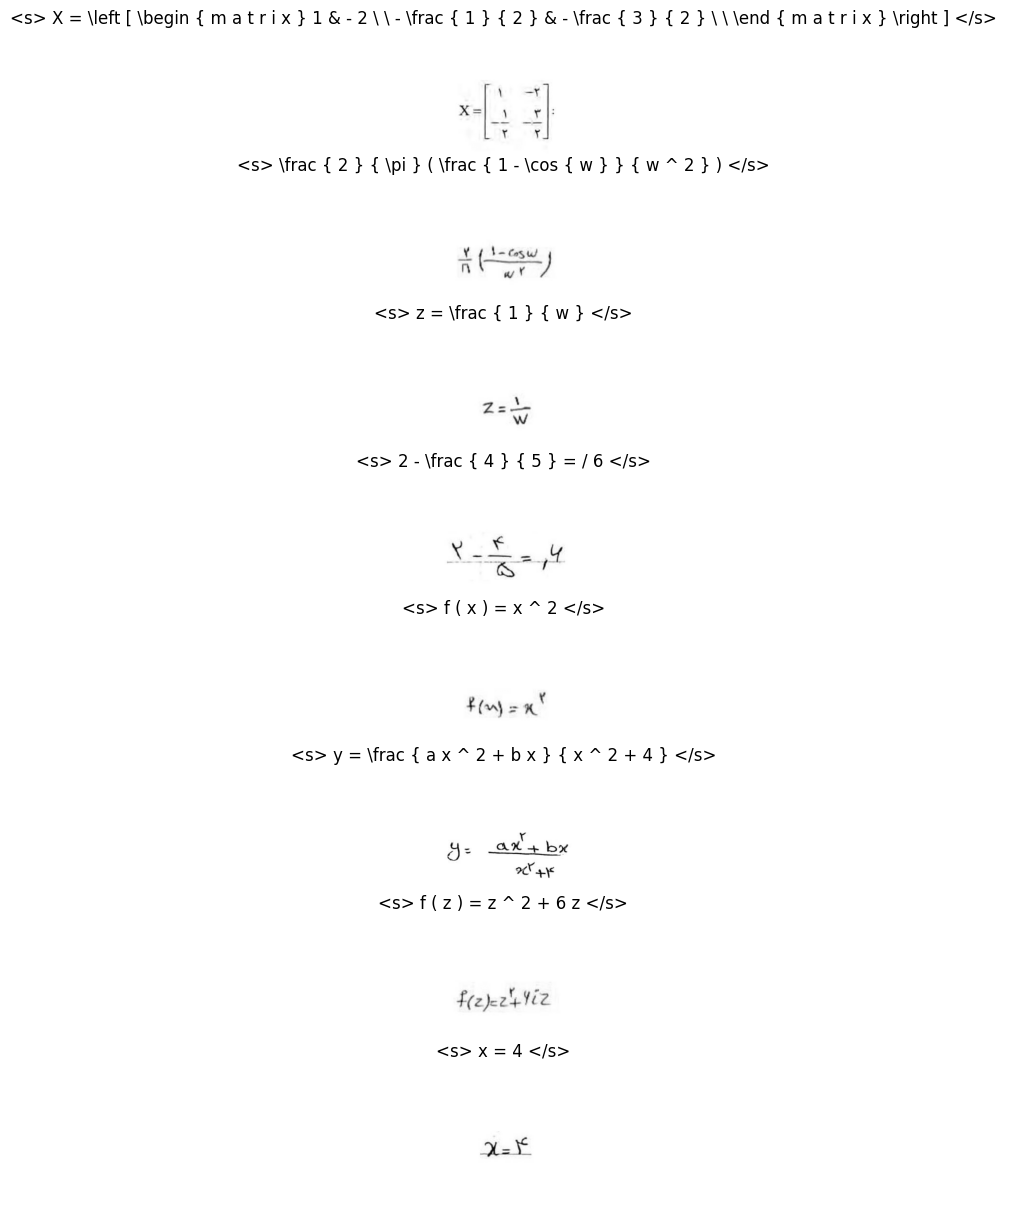

In [42]:
import matplotlib.pyplot as plt

# 5 تصویر از test_loader دریافت کن
batch = next(iteration)
images, _ = batch  # فقط تصاویر را می‌گیریم

# 5 تصویر اول را انتخاب کن
num_images = 8
image_tensors = images[:num_images].to(device)

# نمایش و پیش‌بینی تصاویر
fig, axes = plt.subplots(num_images, 1, figsize=(5, 15))

with torch.no_grad():
  for i in range(num_images):
      image_tensor = image_tensors[i]

      # پردیکت کردن
      pred = lit_model.model.predict(image_tensor.unsqueeze(0).float())[0]  # type: ignore
      decoded = []  # type: ignore
      for j in pred.tolist():
        if j!=3:
          decoded.append(lit_model.tokenizer.id_to_token(j))
      decoded.append("\n")
      decoded_str = " ".join(decoded)

    # نمایش تصویر
      axes[i].imshow(image_tensor.permute(1, 2, 0).cpu().numpy(), cmap="gray")  # اگر رنگی نیست cmap="gray" بگذار
      axes[i].axis("off")
      axes[i].set_title(decoded_str)

plt.show()


In [43]:
trainer = Trainer(**config['trainer'])
test_results = trainer.test(lit_model, dataloaders=test_loader)

# نمایش میانگین تست لاس
print(f"Test Loss: {test_results[0]['test/loss']:.4f}")
print(f"Test CER: {test_results[0]['test/cer']:.4f}")


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

RuntimeError: Expected target size [16, 156], got [16, 69]